In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from numpy import inf

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO6_preprocessed.csv', parse_dates=['datetime'])

data.drop(['reservoir_capacity', 'reservoir_levels'], 1, inplace=True)

data['price_pct_change'] = data['price'].pct_change()
data['volatility'] = data['price_pct_change'].rolling(window=24).std()
data.set_index('datetime', inplace=True)



/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_34495/661396674.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop(['reservoir_capacity', 'reservoir_levels'], 1, inplace=True)


In [2]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [3]:
def prepare_data_lstm(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:364*24*3] 
    test_set = dataset_for_prediction[364*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1,1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1,1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    # reshape input data into 3D tensor (batch_size, seq_len, input_size)
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [4]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data_lstm(data)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim + exog_dim, output_dim)

    def forward(self, x, exog):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = torch.cat((out[:, -1, :], exog.view(exog.size(0), -1)), dim=1)
        out = self.fc(out)
        return out

# set hyperparameters
input_dim = train_X.shape[2]
output_dim = 1
hidden_dim = 15
num_layers = 4
batch_size = 97
exog_dim = train_X.shape[2]
seq_length=22

#Trial 20 finished with value: 0.02964043617248535 and parameters: {'hidden_dim': 15, 'num_layers': 4, 'dropout': 0.21109869589375793, 'lr': 0.0005113226180926156, 'batch_size': 97, 'seq_length': 22}. Best is trial 20 with value: 0.02964043617248535.


# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout = 0.21109869589375793
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length).to(device)

# set loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005113226180926156)

# train model
num_epochs = 150
for epoch in range(num_epochs):
    for i in range(0, train_X.shape[0] - batch_size, batch_size):
        # get batch of data
        x = torch.tensor(train_X[i:i+batch_size]).float().to(device)
        y = torch.tensor(train_y[i:i+batch_size]).float().to(device)
        exog = torch.tensor(train_X[i:i+batch_size, -exog_dim:]).float().to(device)

        # forward pass
        outputs = model(x, exog)
        loss = criterion(outputs, y)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [0/150], Loss: 0.0327
Epoch [10/150], Loss: 0.0207
Epoch [20/150], Loss: 0.0125
Epoch [30/150], Loss: 0.0122
Epoch [40/150], Loss: 0.0114
Epoch [50/150], Loss: 0.0108
Epoch [60/150], Loss: 0.0106
Epoch [70/150], Loss: 0.0101
Epoch [80/150], Loss: 0.0096
Epoch [90/150], Loss: 0.0090
Epoch [100/150], Loss: 0.0085
Epoch [110/150], Loss: 0.0084
Epoch [120/150], Loss: 0.0084
Epoch [130/150], Loss: 0.0084
Epoch [140/150], Loss: 0.0083


RMSE: 30276.2790, MAPE: 33.9235% , MAE:  21326.3114, RSS:  1891971930865.8201


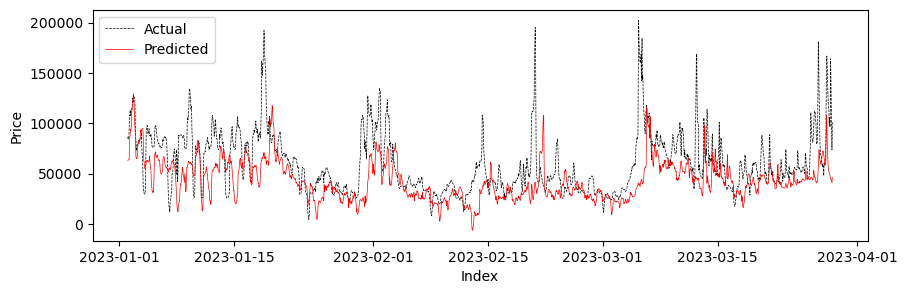

In [6]:


# evaluate model
model.eval()
preds = []
for i in range(0, test_X.shape[0]):
    x = torch.tensor(test_X[i]).float().to(device).unsqueeze(0)
    exog = torch.tensor(test_X[i, -exog_dim:]).float().to(device)
    y_pred = model(x, exog).cpu().detach().numpy().squeeze()
    preds.append(y_pred)

# invert scaling to get unscaled predictions
preds = np.array(preds).reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)
# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, linestyle='--', c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [7]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [8]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=365, test_size=24)
mape = []
rmse=[]
mae=[]
forecast = pd.Series()

# set hyperparameters
hidden_dim = 41
num_layers = 3
dropout = 0.06066797078286349
lr = 8.707743672846187e-05
batch_size=64
seq_length=24

# initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout, batch_size, seq_length).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 10
for fold, (train_index, val_index) in enumerate(tscv.split(train_X)):
    print(f"Fold {fold+1}/{tscv.get_n_splits()}")

    for epoch in range(num_epochs):
        for i in range(0, train_index.shape[0] - batch_size, batch_size):
            # get batch of data
            x = torch.tensor(train_X[train_index][i:i+batch_size]).float().to(device)
            y = torch.tensor(train_y[train_index][i:i+batch_size]).float().to(device)
            exog = torch.tensor(train_X[train_index][i:i+batch_size, -exog_dim:]).float().to(device)

            # forward pass
            outputs = model(x, exog)
            loss = criterion(outputs, y)

            # backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')
    
    preds = []
    for i in range(val_index.shape[0]):
        x = torch.tensor(train_X[val_index][i]).float().to(device).unsqueeze(0)
        exog = torch.tensor(train_X[val_index][i, -exog_dim:]).float().to(device)
        y_pred = model(x, exog).cpu().detach().numpy().squeeze()
        preds.append(y_pred)
    
    # invert scaling to get unscaled predictions
    preds = np.array(preds).reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])

    y_val = np.array(train_y[val_index]).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    # Calculate RMSE and MAPE for this prediction
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mape.append(mean_absolute_percentage_error(y_val, preds))
    mae.append(mean_absolute_error(y_val, preds))

# Calculate and print mean RMSE and MAPE over all predictions
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Fold 1/365


/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_34495/3221729192.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast = pd.Series()


Epoch [0/10], Loss: 0.2612
Fold 2/365
Epoch [0/10], Loss: 0.0045
Fold 3/365
Epoch [0/10], Loss: 0.0020
Fold 4/365
Epoch [0/10], Loss: 0.0027
Fold 5/365
Epoch [0/10], Loss: 0.0029
Fold 6/365
Epoch [0/10], Loss: 0.0019
Fold 7/365
Epoch [0/10], Loss: 0.0026
Fold 8/365
Epoch [0/10], Loss: 0.0030
Fold 9/365
Epoch [0/10], Loss: 0.0024
Fold 10/365
Epoch [0/10], Loss: 0.0022
Fold 11/365
Epoch [0/10], Loss: 0.0053
Fold 12/365
Epoch [0/10], Loss: 0.0045
Fold 13/365
Epoch [0/10], Loss: 0.0052
Fold 14/365
Epoch [0/10], Loss: 0.0050
Fold 15/365
Epoch [0/10], Loss: 0.0045
Fold 16/365
Epoch [0/10], Loss: 0.0018
Fold 17/365
Epoch [0/10], Loss: 0.0020
Fold 18/365
Epoch [0/10], Loss: 0.0017
Fold 19/365
Epoch [0/10], Loss: 0.0007
Fold 20/365
Epoch [0/10], Loss: 0.0008
Fold 21/365
Epoch [0/10], Loss: 0.0006
Fold 22/365
Epoch [0/10], Loss: 0.0004
Fold 23/365
Epoch [0/10], Loss: 0.0005
Fold 24/365
Epoch [0/10], Loss: 0.0006
Fold 25/365
Epoch [0/10], Loss: 0.0004
Fold 26/365
Epoch [0/10], Loss: 0.0005
Fold 2

Fold 209/365
Epoch [0/10], Loss: 0.0006
Fold 210/365
Epoch [0/10], Loss: 0.0007
Fold 211/365
Epoch [0/10], Loss: 0.0009
Fold 212/365
Epoch [0/10], Loss: 0.0008
Fold 213/365
Epoch [0/10], Loss: 0.0009
Fold 214/365
Epoch [0/10], Loss: 0.0011
Fold 215/365
Epoch [0/10], Loss: 0.0010
Fold 216/365
Epoch [0/10], Loss: 0.0005
Fold 217/365
Epoch [0/10], Loss: 0.0005
Fold 218/365
Epoch [0/10], Loss: 0.0004
Fold 219/365
Epoch [0/10], Loss: 0.0006
Fold 220/365
Epoch [0/10], Loss: 0.0004
Fold 221/365
Epoch [0/10], Loss: 0.0003
Fold 222/365
Epoch [0/10], Loss: 0.0004
Fold 223/365
Epoch [0/10], Loss: 0.0003
Fold 224/365
Epoch [0/10], Loss: 0.0002
Fold 225/365
Epoch [0/10], Loss: 0.0002
Fold 226/365
Epoch [0/10], Loss: 0.0001
Fold 227/365
Epoch [0/10], Loss: 0.0018
Fold 228/365
Epoch [0/10], Loss: 0.0017
Fold 229/365
Epoch [0/10], Loss: 0.0607
Fold 230/365
Epoch [0/10], Loss: 0.0591
Fold 231/365
Epoch [0/10], Loss: 0.0561
Fold 232/365
Epoch [0/10], Loss: 0.0337
Fold 233/365
Epoch [0/10], Loss: 0.0313


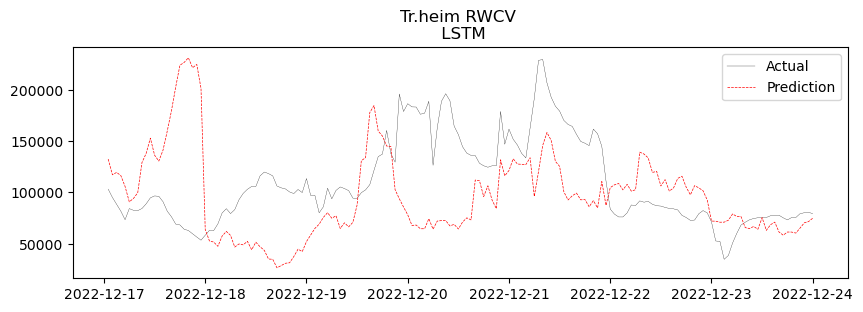

In [9]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*16:-24*9].values, train_set['target'][-24*16:-24*9].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*16:-24*9].values, forecast[-24*16:-24*9], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n LSTM')
plt.legend()
plt.show()

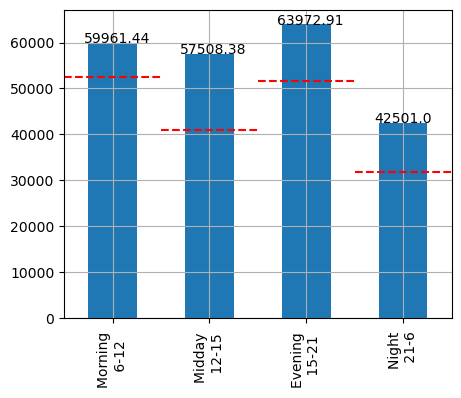

In [10]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31766, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    
plt.show()

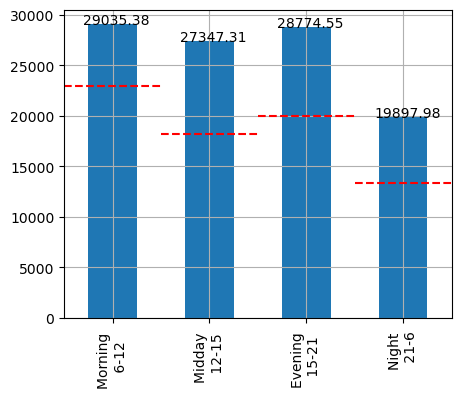

In [11]:

mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))



plt.show()